In [ ]:
!git clone https://github.com/laxmimerit/dog-cat-full-dataset.git

Cloning into 'dog-cat-full-dataset'...
remote: Enumerating objects: 25033, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 25033 (delta 0), reused 4 (delta 0), pack-reused 25027 (from 1)
Receiving objects: 100% (25033/25033), 541.85 MiB | 13.51 MiB/s, done.
Resolving deltas: 100% (5/5), done.
Updating files: 100% (24990/24990), done.


Model Dog_cat classification

In [ ]:
import torch
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from torch import nn
from PIL import Image
from glob import glob
import os
from sklearn.metrics import classification_report
import torch.optim as optim

In [ ]:
class SampleDataset(Dataset):
    def __init__(self, path, transform=None):
        self.paths = glob(path)
        self.labels = [0 if "cats" in os.path.split(os.path.dirname(p))[-1] else 1 for p in self.paths]
        self.transform = transform

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, index):
        image_path = self.paths[index]
        image = Image.open(image_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        label = self.labels[index]
        return image, torch.tensor(label, dtype=torch.long)

In [21]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

In [ ]:
train_dataset = SampleDataset("/content/dog-cat-full-dataset/data/train/*/*", transform=transform)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_dataset = SampleDataset("/content/dog-cat-full-dataset/data/test/*/*", transform=transform)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [ ]:
model1 = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
num_features = model1.fc.in_features
model1.fc = nn.Linear(num_features, 2)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 150MB/s]


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model1 = model1.to(device)

model1.train()
optimizer = optim.Adam(model1.parameters(), lr=0.0001)
loss_fn = nn.CrossEntropyLoss()

In [ ]:
num_epochs = 2
for epoch in range(num_epochs):
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()


        outputs = model1(images)
        loss = loss_fn(outputs, labels)


        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader):.4f}")


model1.eval()


y_pred = []
y_true = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model1(images)
        _, predicted = torch.max(outputs, 1)
        y_pred.extend(predicted.cpu().numpy())
        y_true.extend(labels.cpu().numpy())


print(classification_report(y_true, y_pred, target_names=["Cat", "Dog"]))


Epoch 1/2, Loss: 0.0573
Epoch 2/2, Loss: 0.0313
              precision    recall  f1-score   support

         Cat       0.98      0.99      0.98      2500
         Dog       0.99      0.98      0.98      2500

    accuracy                           0.98      5000
   macro avg       0.98      0.98      0.98      5000
weighted avg       0.98      0.98      0.98      5000



In [18]:
torch.save(model1.state_dict(), "model.pth")

In [19]:
pip install selectivesearch

In [ ]:
import cv2
import selectivesearch
import matplotlib.pyplot as plt

Selective Search

Số vùng được đề xuất: 25


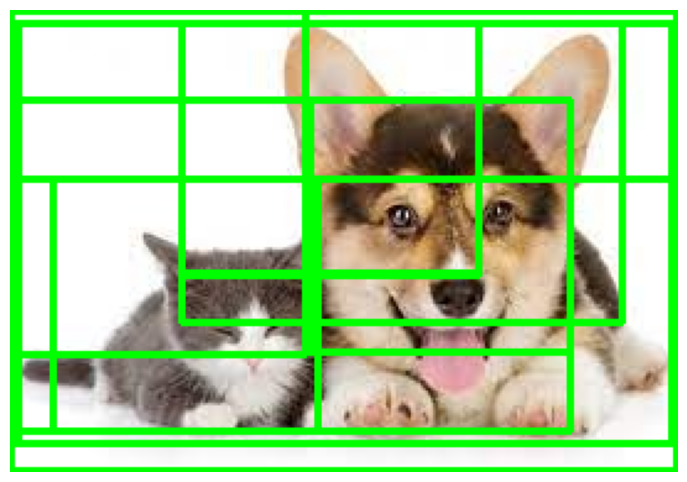

In [48]:
image_path = 'dog_cat.jpg'
image = cv2.imread(image_path)

# Convert image to RGB (matplotlib hiển thị ảnh theo RGB, OpenCV đọc ảnh theo BGR)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Apply Selective Search
_, regions = selectivesearch.selective_search(image, scale=500, sigma=0.9, min_size=50)

# Extract bounding boxes
proposals = [r['rect'] for r in regions]
min_width, min_height = 100, 100
proposals = [(x, y, w, h) for (x, y, w, h) in proposals if w >= min_width and h >= min_height]


print(f"Số vùng được đề xuất: {len(proposals)}")

# Draw bounding boxes
output_image = image.copy()
for (x, y, w, h) in proposals[:50]:
    cv2.rectangle(output_image, (x, y), (x + w, y + h), (0, 255, 0), 2)

output_rgb = cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB)


plt.figure(figsize=(10, 6))
plt.imshow(output_rgb)
plt.axis('off')
plt.show()


IOU && NMS

In [41]:
import numpy as np

def iou(box1, box2):
    x1, y1, w1, h1 = box1
    x2, y2, w2, h2 = box2

    xi1 = max(x1, x2)
    yi1 = max(y1, y2)
    xi2 = min(x1 + w1, x2 + w2)
    yi2 = min(y1 + h1, y2 + h2)

    inter_width = max(0, xi2 - xi1)
    inter_height = max(0, yi2 - yi1)
    inter_area = inter_width * inter_height

    box1_area = w1 * h1
    box2_area = w2 * h2
    union_area = box1_area + box2_area - inter_area

    return inter_area / union_area if union_area != 0 else 0

def non_max_suppression(boxes, scores, threshold=0.3):
    idxs = np.argsort(scores)[::-1]
    keep = []

    while len(idxs) > 0:
        best_idx = idxs[0]
        keep.append(best_idx)

        remove_idxs = []
        for i in range(1, len(idxs)):
            if iou(boxes[best_idx], boxes[idxs[i]]) > threshold:
                remove_idxs.append(i)

        idxs = np.delete(idxs, remove_idxs)
        idxs = np.delete(idxs, 0)

    return keep


In [37]:
def predict_region(region):
    region = transform(region).unsqueeze(0).to(device)
    with torch.no_grad():
        output = model(region)
        probs = torch.softmax(output, dim=1)
        confidence, predicted = torch.max(probs, 1)
    return predicted.item(), confidence.item()

In [38]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 2)
model.load_state_dict(torch.load("model.pth"))
model.to(device)
model.eval()

<ipython-input-38-b4727a5fcb65>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("model.pth"))


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

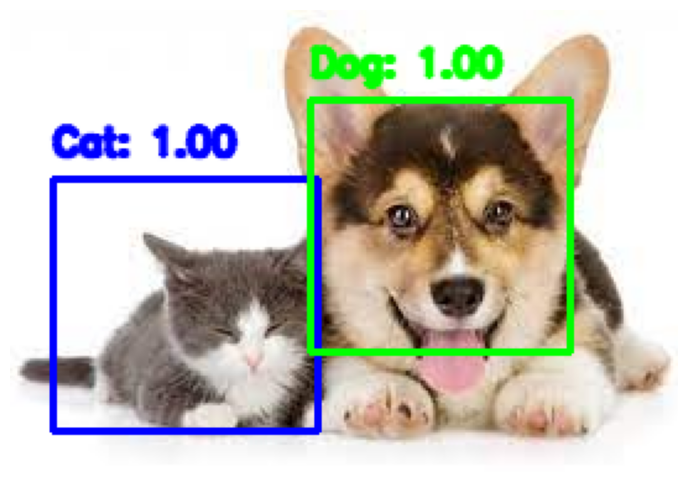

In [49]:
boxes = []
scores = []
labels = []
output_image = image.copy()

for (x, y, w, h) in proposals:
    region = image[y:y+h, x:x+w]
    if region.shape[0] > 0 and region.shape[1] > 0:
        region_pil = Image.fromarray(cv2.cvtColor(region, cv2.COLOR_BGR2RGB))
        label, confidence = predict_region(region_pil)

        if confidence > 0.7:
            boxes.append((x, y, w, h))
            scores.append(confidence)
            labels.append(label)


keep_idxs = non_max_suppression(boxes, scores, threshold=0.1)

for i in keep_idxs:
    x, y, w, h = boxes[i]
    label_text = "Dog" if labels[i] == 1 else "Cat"
    confidence_text = f"{label_text}: {scores[i]:.2f}"
    color = (0, 255, 0) if labels[i] == 1 else (255, 0, 0)

    cv2.rectangle(output_image, (x, y), (x + w, y + h), color, 2)


    cv2.putText(output_image, confidence_text, (x, y - 10),
                cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2, cv2.LINE_AA)


plt.figure(figsize=(10, 6))
plt.imshow(cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()